<a href="https://colab.research.google.com/github/natbcar/MachineLearning/blob/main/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt 

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Make a dict mapping labels to names of clothing items 
label_dict = {
    0 : "T-shirt/top",
    1 : "Trouser", 
    2 : "Pullover",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneaker",
    8 : "Bag",
    9 : "Ankle boot"
}

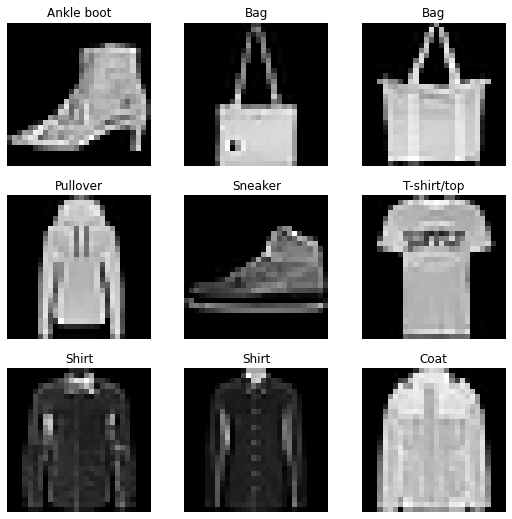

In [ ]:
for i in range(1, cols*rows+1):
  rand_idx = torch.randint(len(training_data), size=(1,)).item()  # get a random idx
  img, label = training_data[rand_idx]
  figure.add_subplot(rows, cols, i)
  # img.squeeze() removes axis with size 1
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(label_dict[label])  # map numerical label to label
  plt.axis("off")

plt.show()

In [ ]:
img, label = training_data[0]
print(img.shape)
img.view(-1, 1, 28, 28).shape

torch.Size([1, 28, 28])


torch.Size([1, 1, 28, 28])

In [ ]:
# --- LeNet ---
class LeNet(nn.Module):
  """
  Class based off of the LeNet architecture. The architecture is mostly the same except
  sigmoid activation functions are replaced with ReLU and average pooling layers 
  are replaced with max pooling layers.
  """
  def __init__(self):
    super(LeNet, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(in_features=16*5*5, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=84),
        nn.ReLU(),
        nn.Linear(in_features=84, out_features=10)
    )

  def forward(self, x):
    logits = self.net(x)
    return logits

In [ ]:
test_model = LeNet()
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)

In [ ]:
# Checking to make sure that our dimensions are right
for layer in test_model.net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [ ]:
# Instantiating data loaders
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
# Switching to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Our device is {}".format(device))

Our device is cuda


In [ ]:
# Initializing hyper params
learning_rate = 1e-3
batch_size = 64
num_epochs = 10

In [ ]:
# Initializing model, objective, optim
model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# Track training loss, validation loss, accuracy
training_loss = []
validation_loss = []
accuracy = []

In [ ]:
for epoch in range(num_epochs):

  # --- Train Model ---
  for i, (X, y) in enumerate(train_loader):

    size = len(train_loader.dataset)

    # --- Compute the prediction and loss ---
    pred = model(X)
    loss = criterion(pred, y)

    # --- Backpropigation ---
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    training_loss.append(loss.item())

    if i % 100 == 0:
      loss, current = loss.item(), i * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  # --- Validate Model ---
  with torch.no_grad():
    size = len(test_loader.dataset)
    avg_loss, avg_acc = 0, 0
    for X, y in test_loader:
      pred = model(X)
      avg_loss += criterion(pred, y)
      avg_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss /= size
    avg_acc /= size

    validation_loss.append(avg_loss)
    accuracy.append(avg_acc)

    print(f"Test Error: \n Accuracy: {(100*avg_acc):>0.1f}%, Avg loss: {avg_loss:>8f} \n")

loss: 2.282090  [    0/60000]
loss: 2.270708  [ 6400/60000]
loss: 2.273023  [12800/60000]
loss: 2.260845  [19200/60000]
loss: 2.264366  [25600/60000]
loss: 2.268752  [32000/60000]
loss: 2.271592  [38400/60000]
loss: 2.251155  [44800/60000]
loss: 2.254325  [51200/60000]
loss: 2.254223  [57600/60000]
Test Error: 
 Accuracy: 28.6%, Avg loss: 0.035318 

loss: 2.246030  [    0/60000]
loss: 2.262243  [ 6400/60000]
loss: 2.245979  [12800/60000]
loss: 2.228698  [19200/60000]
loss: 2.246845  [25600/60000]
loss: 2.208149  [32000/60000]
loss: 2.190394  [38400/60000]
loss: 2.187492  [44800/60000]
loss: 2.141995  [51200/60000]
loss: 2.179872  [57600/60000]
Test Error: 
 Accuracy: 39.8%, Avg loss: 0.033544 

loss: 2.133894  [    0/60000]
loss: 2.103370  [ 6400/60000]
loss: 2.091255  [12800/60000]
loss: 1.980317  [19200/60000]
loss: 2.003520  [25600/60000]
loss: 1.874744  [32000/60000]
loss: 1.776207  [38400/60000]
loss: 1.807345  [44800/60000]
loss: 1.643559  [51200/60000]
loss: 1.619718  [57600/600

In [ ]:
num_correct = 0
for i in range(len(test_data)):
  X, y = test_data[i]
  X = X.view(-1, 1, 28, 28)
  pred = model(X)
  num_correct += (pred.argmax(1) == y)

print("accuracy: {}".format((num_correct / len(test_data)).item()))

accuracy: 0.7024000287055969


In [ ]:
idx = torch.randint(len(test_data), size=(1,)).item()
X, y = test_data[idx]
X = X.view(-1, 1, 28, 28)
pred = model(X)
pred.argmax(1) == y

tensor([True])

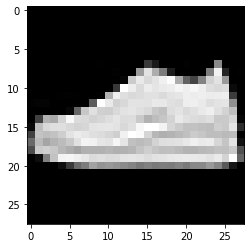

In [ ]:
plt.imshow(X.squeeze(), cmap="gray")

In [ ]:
label_dict[pred.argmax(1).item()]

'Sneaker'